# Testing Hilbert-GP

## A note about units and Fourier convention

Solin & Sarkka (2020) use the following FT convention (Eq. 3):
$$ S(\omega) = \int k(r) \exp(-i r \omega) dr $$
This is different from our preferred convention:
$$ S(f) = \int k(r) \exp(-i 2\pi r f) dr $$
However, these **are completely equivalent to a change of units**:
$$ \omega \ \text{[rad/s]} = 2\pi f \ \text{[Hz]} $$
In other words, results in Solin & Sarkka (2020) are just given in rad/s, rather than Hz. We prefer Hz (which determines our FT convention) because it connects directly to FFTs of the data, and makes things more explicit.

When translating the results in Solin & Sarkka (2020) to our choice of units, the following things transform:
$$ \phi_j(x) \rightarrow \phi_j(x) \ \text{(unchanged)} $$
$$ \sqrt{\lambda_j} = {\pi j \over 2L} \ \text{[rad/s]} \rightarrow \sqrt{\lambda_j} = {j \over 4L} \ \text{[Hz]}$$
$$ S(\omega) \rightarrow S(f) = S(\omega)\vert_{\omega=2\pi f} $$
- The first line is about the eigenfunctions of the Laplace operator (https://en.wikipedia.org/wiki/Eigenvalues_and_eigenvectors_of_the_second_derivative#Mixed_Dirichlet-Neumann_boundary_conditions) and make no mention to frequencies, so are independent of our choice of FT convention.
- The second and third lines cancel eachother out, so we don't have to change our code. However, when interpreting the $\sqrt{\lambda_j}$'s as frequencies, we have to convert them from [rad/s] to [Hz] by dividing them by a factor $(2\pi)$ (as is done in `test_pulse.ipynb`. In our system they can be directly interpreted as frequencies. 
- In the third line, $S(f)$ just corresponds to the spectral densities given in Rasmussen & Williams (2006) (who use our FT convention).

Finally, since our time is generally in msec, the frequencies are kHz rather than Hz. **In `core.py` it is assumed time ($t$ and $T$) is in msec.**

In [1]:
%run init.ipy
from dgf import core
from dgf import isokernels

#config.update("jax_debug_nans", True)

2023-02-17 12:47:50.461834: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-17 12:47:50.461883: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-02-17 12:47:50.461888: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


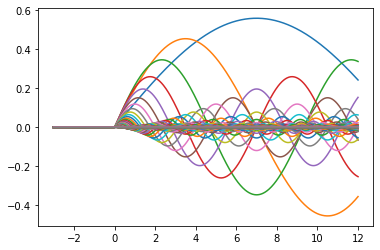

In [2]:
T = 7.
N = 500
M = 128
bf = 2.
L = T*bf
t, dt = jnp.linspace(-3., T+5, N, retstep=True)

kernel = isokernels.Matern32Kernel
var = 0.5
r = 1/np.pi
scale = r*T

R = core.kernelmatrix_root_hilbert(kernel, var, scale, t, M, L)
plot(t, core.impose_domain(R, t, 0., L));

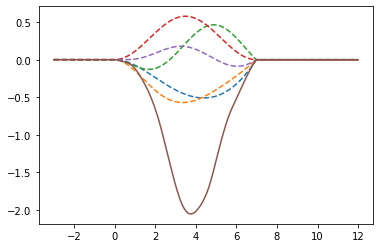

In [3]:
Ru = core.kernelmatrix_root_gfd(kernel, var, scale, t, M, T, bf)

plot(t, jnp.cumsum(Ru[:,:5], axis=0)*dt, ls="--");
plot(t, cumsum(Ru @ randn(M))*dt);

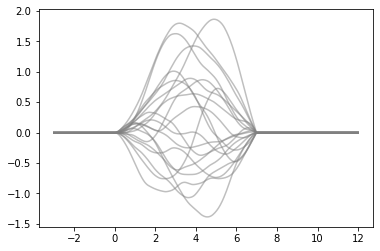

In [4]:
Ru = core.kernelmatrix_root_gfd(kernel, var, scale, t, M, T, bf)

#plot(t, jnp.cumsum(Ru[:,:5], axis=0)*dt, ls="--");
for i in range(20):
    plot(t, cumsum(Ru @ randn(M))*dt, alpha=0.5, color="grey");

[Memory]7.4s, 0.1min    : Loading posterior_of_fitted_TFB_values...
[Memory]7.7s, 0.1min    : Loading run_nested...
[Memory]7.7s, 0.1min    : Loading get_vtrformants_training_data...
[Memory]25.3s, 0.4min   : Loading run_nested...
[Memory]26.2s, 0.4min   : Loading run_nested...
[Memory]27.0s, 0.5min   : Loading run_nested...
[Memory]27.9s, 0.5min   : Loading run_nested...


/home/marnix/thesis/py/dgf/bijectors.py:482: UserWarning: No observations to condition bijector on; returning original bijector
  warnings.warn("No observations to condition bijector on; returning original bijector")


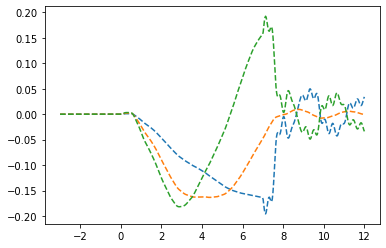

In [5]:
from vtr.prior import filter

vtfilter = filter.PZ(7, numpy_backend=jax.numpy, scipy_backend=jax.scipy)

xy = filter.filter_marginal_prior(vtfilter).sample(seed=jaxkey())
x, y = xy.split(2)

poles = vtfilter.poles(x, y)
c = vtfilter.pole_coefficients(x, y, vtfilter.randw())

phi = core.phi_transfer_matrix(t, M, T, L, poles, c)

plot(t, phi[:,:3], ls="--");

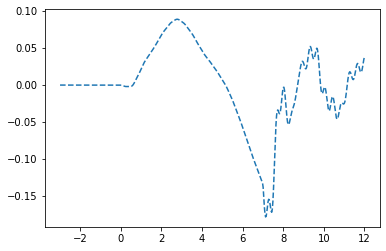

In [6]:
R = core.kernelmatrix_root_convolved_gfd(
    kernel, var, scale, t, M, T, bf, poles, c, impose_null_integral=True
)
plot(t, R[:,:1], ls="--");

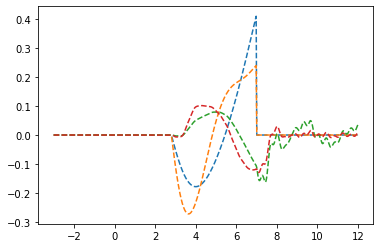

In [7]:
Oq = .6

R = core.kernelmatrix_root_gfd_oq(
    kernel, var, r, t, M, T, Oq, bf, impose_null_integral=True
)
plot(t, R[:,:2], ls="--");

R = core.kernelmatrix_root_convolved_gfd_oq(
    kernel, var, r, t, M, T, Oq, bf, poles, c, impose_null_integral=True
)
plot(t, R[:,:2], ls="--");

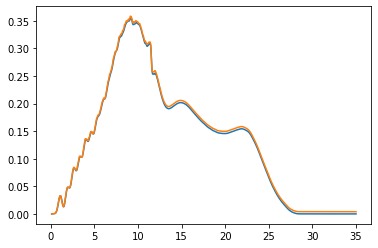

In [8]:
# Test grad T

@jax.jit
def test_grad_T(T):
    R = core.kernelmatrix_root_convolved_gfd_oq(
        kernel, var, r, t, M, T, Oq, bf, poles, c
    )
    return jnp.sum(R.T @ R) # Just invent a random scalar function

# Grad T can produce nans for excessively smooth spectral densities
# i.e. SqExponentialKernel and CenteredSincKernel. Then we just have
# to decrease the scale parameter, but the `r = length/T` parametrization
# takes care of this automatically.
dtest_grad_T = jax.jit(jax.grad(test_grad_T))

Ts, dT = jnp.linspace(.1, 35, 1000, retstep=True)

f = np.array([test_grad_T(T) for T in Ts])
df = np.array([dtest_grad_T(T) for T in Ts])*dT

plot(Ts, f)
plot(Ts, cumsum(df))

In [9]:
w = randn(M)
f = R @ w
%timeit jnp.linalg.lstsq(R, f)

9.01 ms ± 31.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


75


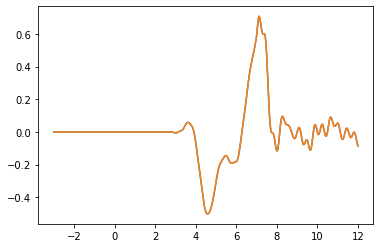

In [10]:
w = randn(M)
f = R @ w
x, res, rank, s = jnp.linalg.lstsq(R, f)
print(rank)
plot(t, f)
plot(t, R @ x)

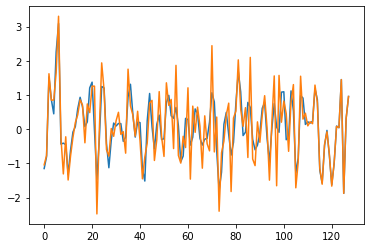

In [11]:
plot(x)
plot(w)

In [12]:
%timeit jnp.linalg.lstsq(R, f)

9.05 ms ± 2.87 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [13]:
jlstsq = jax.jit(jnp.linalg.lstsq)
%timeit jlstsq(R, f)

9.08 ms ± 58.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Check the Hilbert kernel on a grid

In [14]:
N = 300
M = 128

t = np.arange(N) # Grid
y = np.random.rand(N)   # Data lying on the grid
L = N - 1        # Endpoint of the compact domain `[0, L]`

kernel = isokernels.Matern32Kernel
var = 1.3
scale = 2.5
noise_power = .1

# Calculate the log likelihood using the general method
R = core.kernelmatrix_root_hilbert(kernel, var, scale, t, M, L)
L = core.loglikelihood_hilbert(R, y, noise_power)

# Now make use of the fact that the grid spans the compact domain `[0, L]`
L_grid = core.loglikelihood_hilbert_grid(kernel, var, scale, M, y, noise_power)

np.isclose(L, L_grid)

True

In [15]:
%timeit core.loglikelihood_hilbert_grid(kernel, var, scale, M, y, noise_power)

2.72 ms ± 26.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [16]:
%timeit core.loglikelihood_hilbert(R, y, noise_power)

1.5 ms ± 67.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [17]:
jitted = jax.jit(core.loglikelihood_hilbert)

%timeit jitted(R, y, noise_power).block_until_ready()

515 µs ± 3.72 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
